In [75]:
%matplotlib inline

In [76]:
## imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import pandas as pd
from scipy import optimize
from prettytable import PrettyTable
from datetime import datetime
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from scipy.integrate import simpson
from scipy import signal


# for fun
plt.style.use("basic.mplstyle")
print("All thrusters go!")

All thrusters go!


### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

### Austen Fourkas

The point of this Midterm is to 
- cover material that we haven't had a chance to put on a homework yet
- throw in a curveball that will require you to actually understand the material you learned
- generally give me a sense of where you all are at the halfway point 

# Q1. Noise, Simulations and Fourier Transforms ( 40 pts)

You should probably begin by reading this short article on how to generate noise
https://paulbourke.net/fractals/noise/

Generate the following time streams: 
- 5.5 Hz signal
- "dirty" 60 Hz signal (hint: https://ep2000.com/what-is-dirty-electricity-and-how-to-remove-it-from-your-home/?v=e75edac1b83f - how you generate the noise is up to you - you can round the value of a sine wave for instance to the nearest something)
- white noise
- Brownian noise
- 1/f noise
- sum of all the above

8 points each:

a) Plot the time streams and make the plot pretty (I'm not being as specific as before because you ought to know by now). ✅

b) Measure the standard deviation of each noise time stream. Count and report the number of time samples above (or below) 3 sigma. ✅

c) Fourier Transform the time streams and plot the power spectral densities ✅

d) Do a power law fit and measure the slope of the noise components. What is alpha (1/f^alpha) for the various components? (Report an error) Show your fits. (https://scipy-cookbook.readthedocs.io/items/FittingData.html) ✅

e) To the total timestream: (3 + 3 + 2)
- apply a high-pass filter ✅
- apply a low-pass filter ✅
- plot the power spectral density ✅

In [77]:
## time space
t_space = np.linspace(0, 1, 10000)

## dataframe
dataframe = pd.DataFrame(t_space, columns=["time"])

In [78]:
## signal generator
def make_wave(time, frequency, noise):
    omega = 2 * np.pi * frequency
    if noise == "clean":
        signal = np.sin(omega * time)
    if noise == "sine":
        wave_array_clean = np.sin(omega * time)
        noise_generation = np.random.normal(0, 0.2, len(time))
        signal = wave_array_clean + noise_generation
    if noise == "white":
        signal_gen = np.random.normal(0, 1, len(time))
        signal = signal_gen / (np.amax(signal_gen))
    if noise == "brown":
        white = np.random.normal(0, 1, len(time))
        signal_array = np.zeros(len(white))
        for i in range(0, len(white)):
            integral = simpson(white[0 : i + 1], x=t_space[0 : i + 1])
            signal_array[i] = integral
        signal = signal_array
    if noise == "pink":
        point = abs(np.random.normal(0, 0.5, 1))
        signal_array = np.zeros(len(time))
        signal_array[0] = point
        for i in range(len(time) - 1):
            signal_array[i + 1] = (signal_array[i] + signal_array[i] ** 2) % 1
        signal = signal_array
    else:
        pass
    return signal

In [79]:
## clean 5.5 Hz signal
wave_1 = make_wave(t_space, 5.5, "clean")
dataframe["clean"] = wave_1

## dirty 60 Hz signal
wave_2 = make_wave(t_space, 60, "sine")
dataframe["sine"] = wave_2

## white noise
wave_3 = make_wave(t_space, 0, "white")
dataframe["white"] = wave_3

## brown noise
wave_4 = make_wave(t_space, 0, "brown")
dataframe["brown"] = wave_4

## 1/f (pink) noise
wave_5 = make_wave(t_space, 0, "pink")
dataframe["pink"] = wave_5

## sum
wave_6 = wave_1 + wave_2 + wave_3 + wave_4 + wave_5
dataframe["total"] = wave_6

/var/folders/zr/h9ws520j7x147p8l8znhwm800000gn/T/ipykernel_10653/4234618479.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  signal_array[0] = point


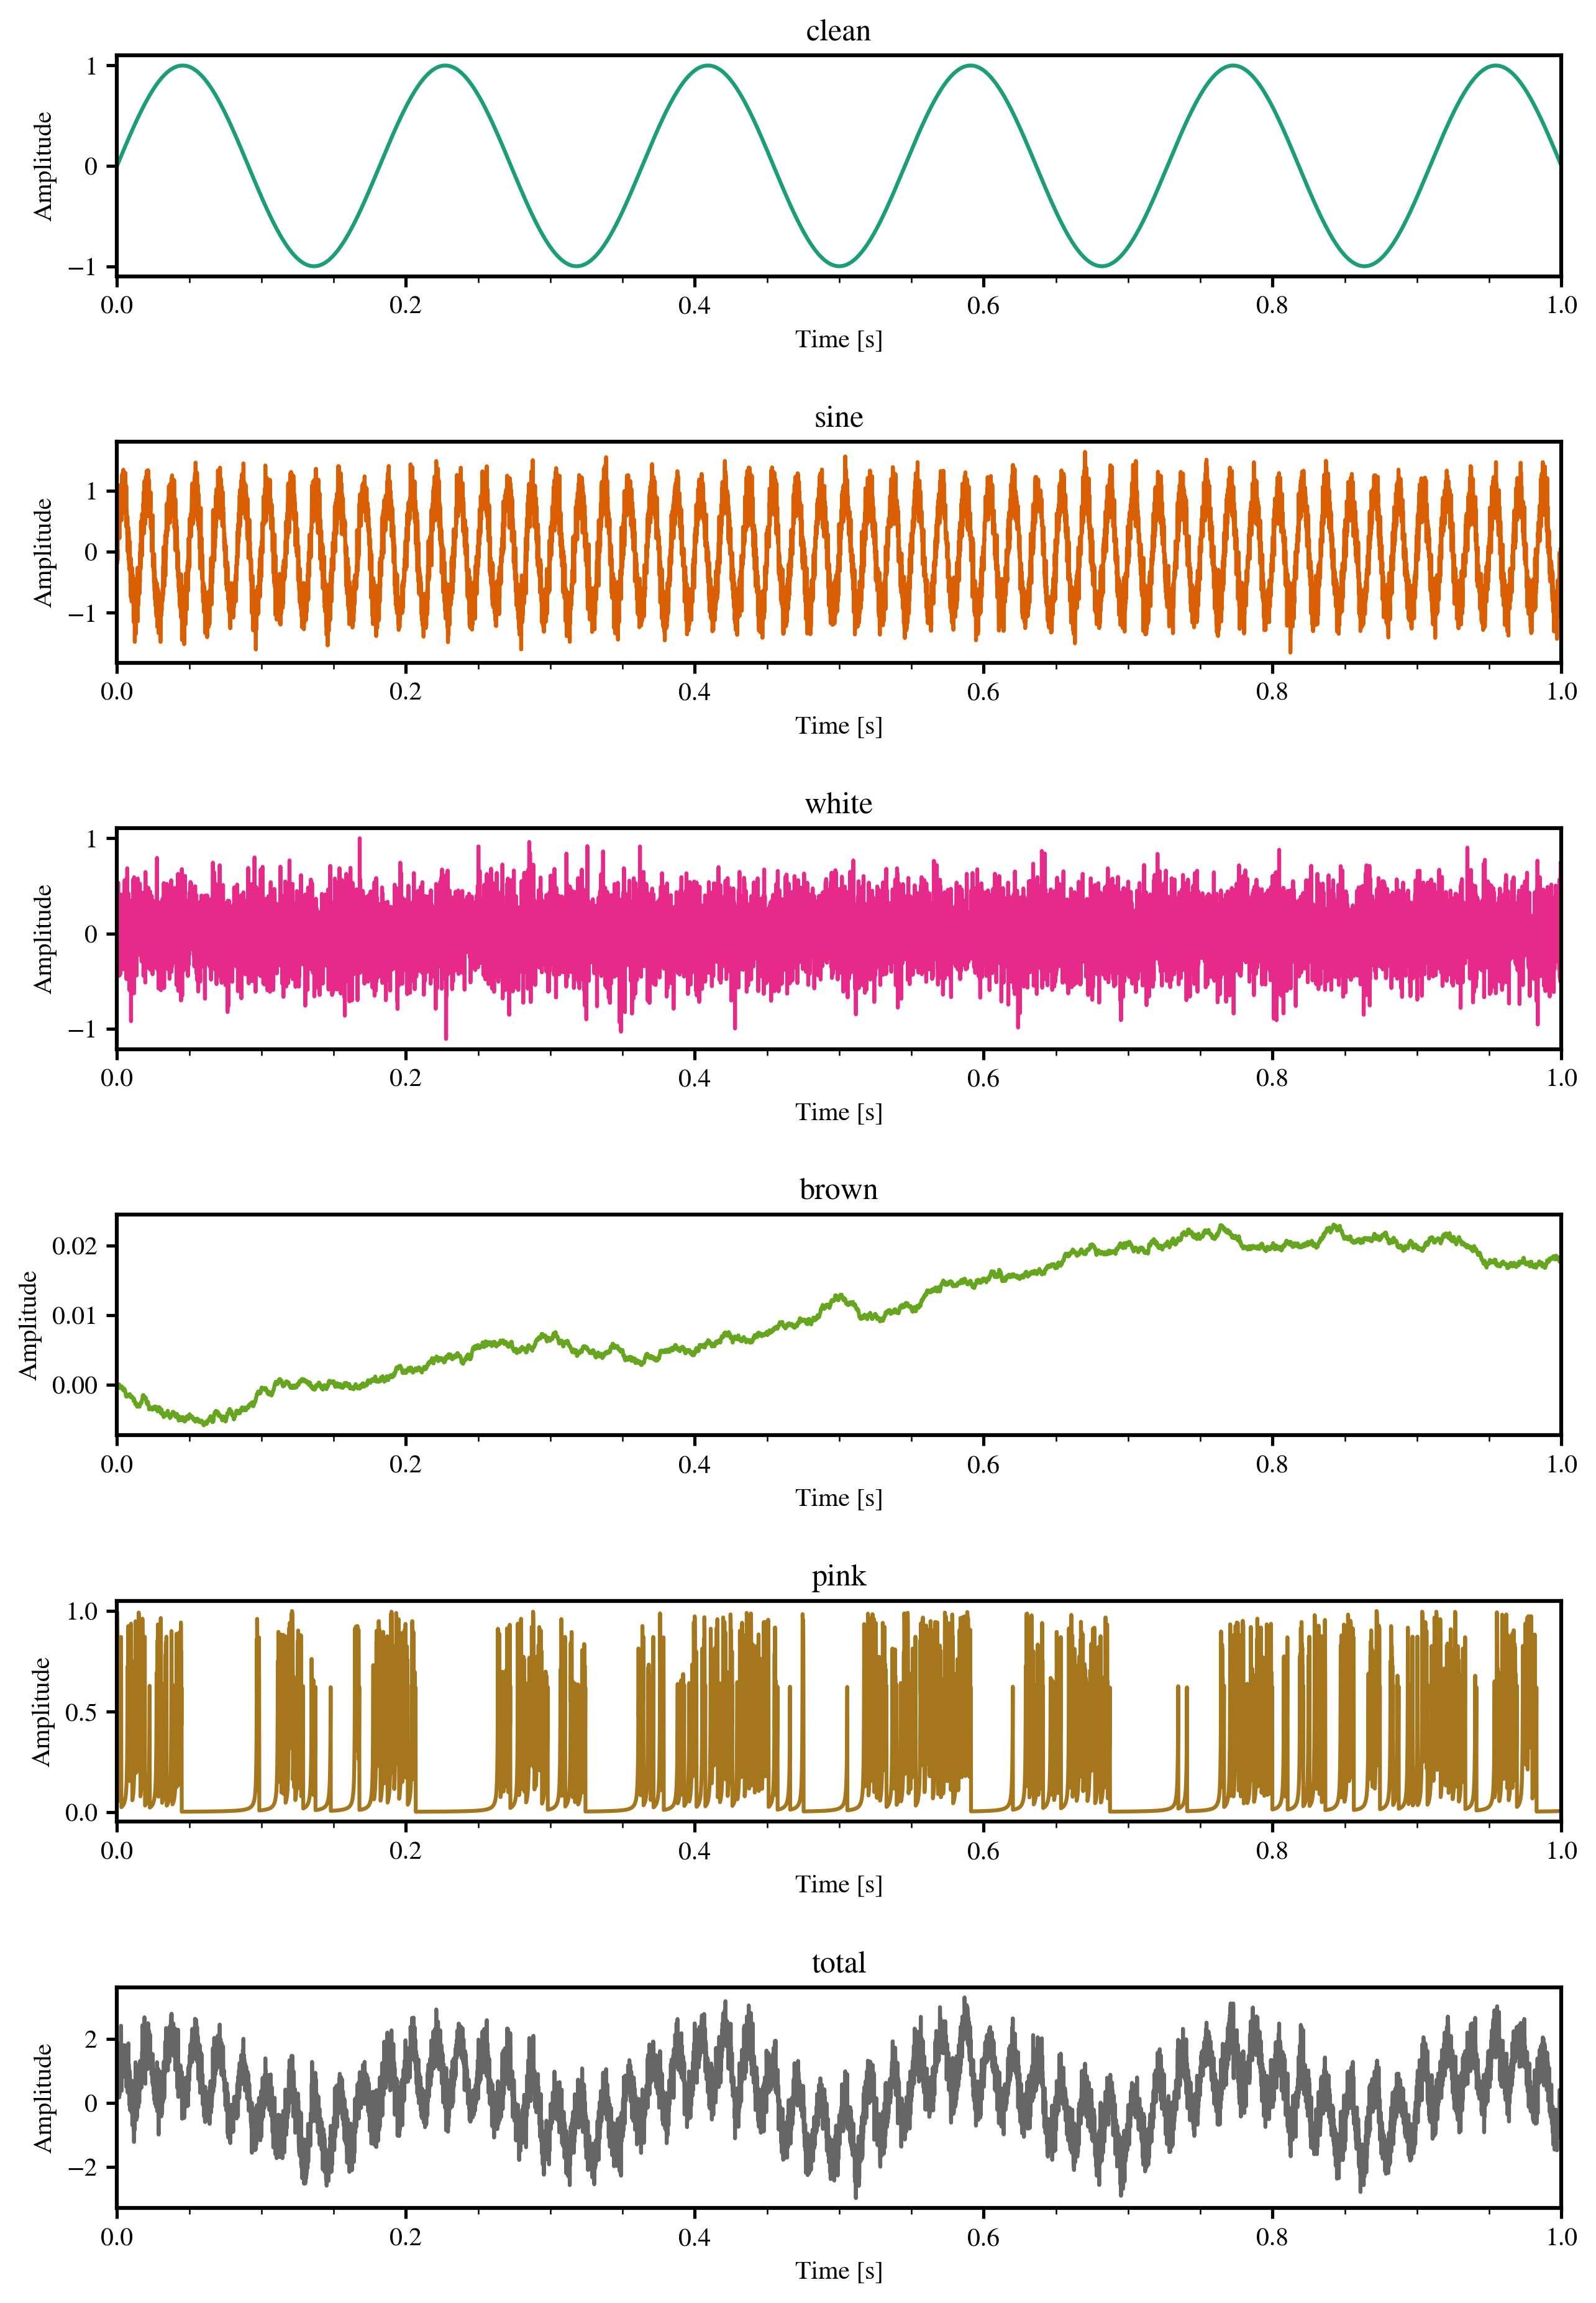

In [80]:
# plotting list
noise_list = ["clean", "sine", "white", "brown", "pink", "total"]

# colors
color = plt.cm.Dark2(np.linspace(0, 1, len(noise_list)))

## plotting

# make axes
fig = plt.figure(figsize=(10, 15))
gspec = fig.add_gridspec(6, hspace=0.75)
axs = gspec.subplots(sharex=False, sharey=False)

# plot and label
for ax_i, ax in enumerate(axs):
    ax.plot(
        dataframe["time"],
        dataframe[noise_list[ax_i]],
        color=color[ax_i],
        label=f"{noise_list[ax_i]}",
    )

    # limits
    ax.set_xlim([0, 1])

    # labels
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude")
    ax.set_title(f"{noise_list[ax_i]}")

    # ticks
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))

plt.show()

In [81]:
## sigma counting
above = []
below = []
sigma = []
for i, noise in enumerate(noise_list):
    median = np.median(dataframe[f"{noise}"])
    sigma_val = np.round(np.std(dataframe[f"{noise}"]), 3)
    n_above = dataframe[f"{noise}"] > (3 * sigma_val) + median
    n_above = len(np.delete(n_above, np.where(n_above == False)))
    n_below = dataframe[f"{noise}"] < (3 * sigma_val) + median
    n_below = len(np.delete(n_below, np.where(n_below == False)))
    sigma.append(sigma_val)
    above.append(n_above)
    below.append(n_below)

table = [noise_list, sigma, above, below]
tab = PrettyTable(table[0])
tab.add_rows(table[1:])
tab.add_column("", ["sigma", "# above", "# below"], align="l", valign="t")
print(tab)

+-------+-------+-------+-------+-------+-------+---------+
| clean |  sine | white | brown |  pink | total |         |
+-------+-------+-------+-------+-------+-------+---------+
| 0.705 | 0.736 | 0.272 | 0.009 | 0.254 | 1.092 | sigma   |
|   0   |   0   |   13  |   0   |  435  |   0   | # above |
| 10000 | 10000 |  9987 | 10000 |  9565 | 10000 | # below |
+-------+-------+-------+-------+-------+-------+---------+


In [82]:
## fourier transforms (run this once per restart)

## frequencies
k = np.fft.fftfreq(
    len(dataframe["time"]), d=(dataframe["time"][1] - dataframe["time"][0])
)
k_pos = k[k > 0]
fft_frame = pd.DataFrame(k_pos, columns=["frequency"])

## power spectrum
for i, noise in enumerate(noise_list):
    # calculations

    window = np.hanning(len(dataframe[f"{noise}"]))
    filtering = window * dataframe[f"{noise}"]
    fft_total = np.fft.fft(filtering)
    fft_pos = fft_total[k > 0]

    density_t1 = np.power(abs(fft_total), 2) / len(fft_pos) ** 2
    density_pos = density_t1[k > 0]

    # add to dataframe
    fft_pos_frame = pd.DataFrame(fft_pos, columns=[f"{noise}_fft"])
    density_frame = pd.DataFrame(density_pos, columns=[f"{noise}_density"])
    fft_frame = pd.concat([fft_frame, fft_pos_frame], axis=1)
    fft_frame = pd.concat([fft_frame, density_frame], axis=1)

In [83]:
## fitting

## functions
plaw = lambda x, amp, index: amp * (x**index)
fitting = lambda p, x: p[0] + p[1] * x
diff = lambda p, x, y: fitting(p, x) - y

## arrays
indicies = np.zeros(len(noise_list))
amplitudes = np.zeros(len(noise_list))
errors = np.zeros(len(noise_list))


## fitting loop
for i, noise in enumerate(noise_list):
    p0 = [0, 0]
    fitting_run = optimize.leastsq(
        diff,
        p0,
        args=(
            np.log10(fft_frame["frequency"]),
            np.log10(fft_frame[f"{noise}_density"]),
        ),
        full_output=1,
    )
    results = fitting_run[0]
    cov = fitting_run[1]
    indicies[i] = results[1]
    amplitudes[i] = 10 ** results[0]
    errors[i] = np.sqrt(cov[1][1])

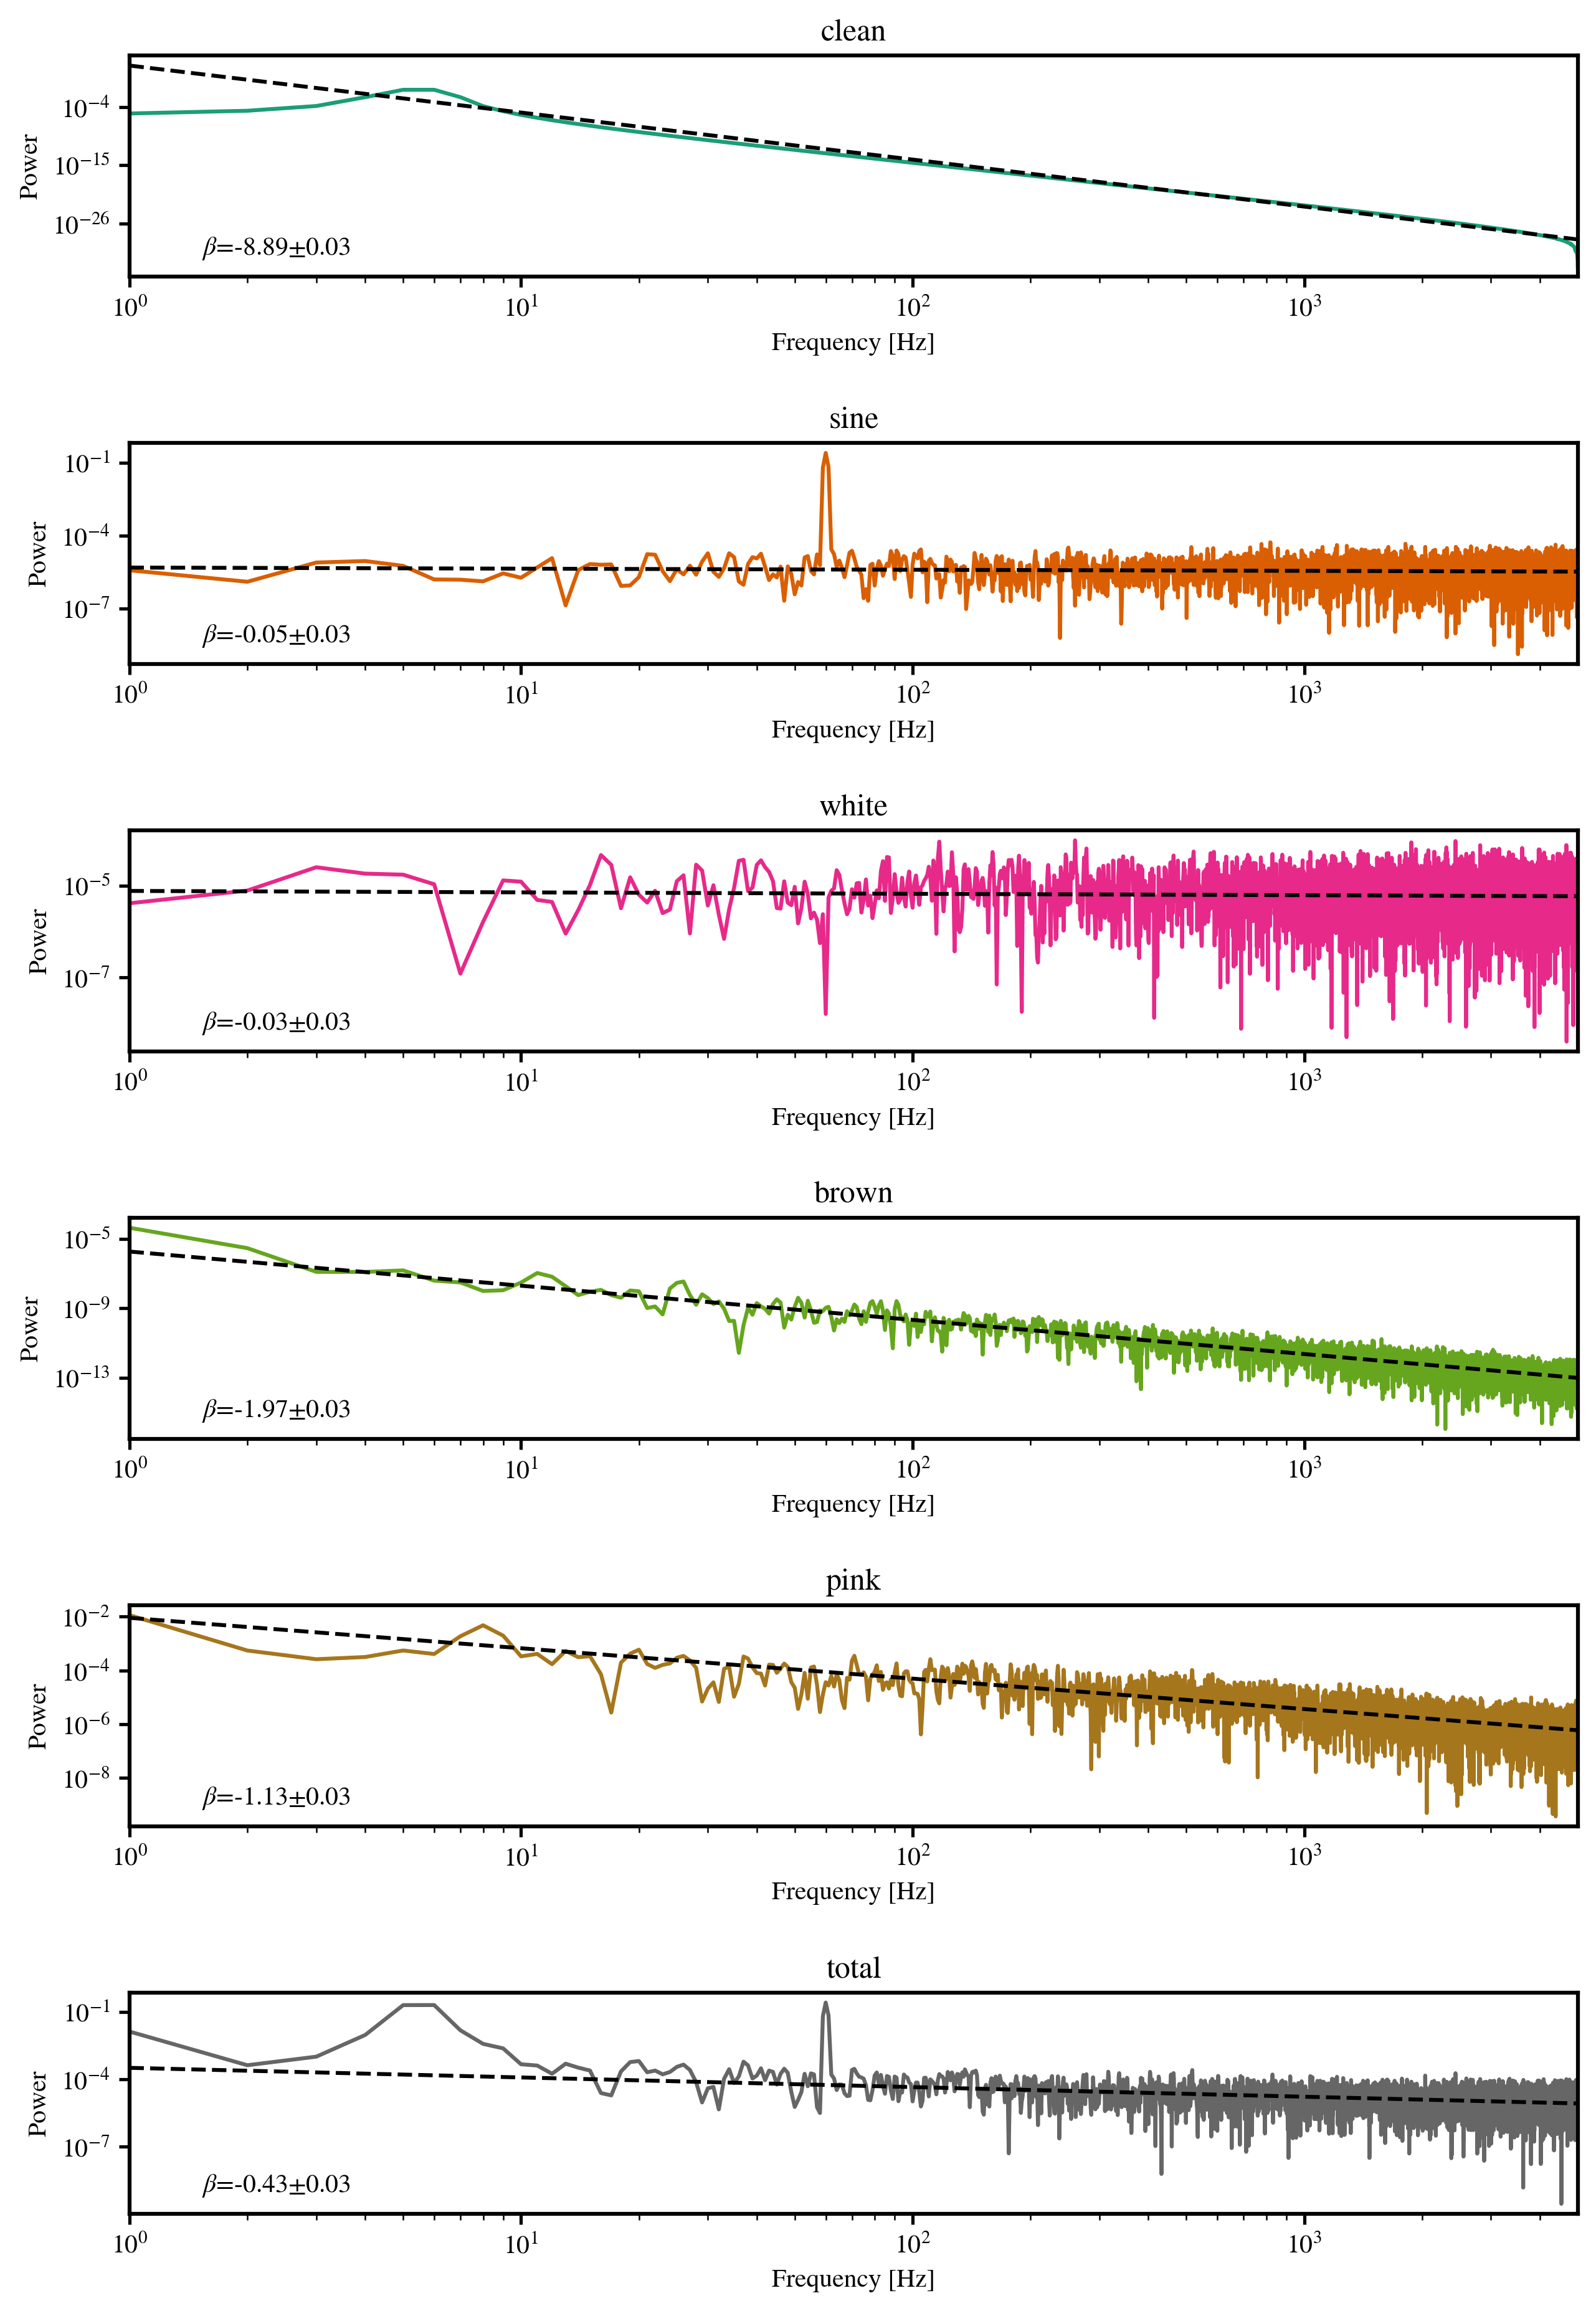

In [84]:
# make axes
fig = plt.figure(figsize=(10, 15))
gspec = fig.add_gridspec(6, hspace=0.75)
axs = gspec.subplots(sharex=False, sharey=False)

color = plt.cm.Dark2(np.linspace(0, 1, len(noise_list)))


# plot and label
for ax_i, ax in enumerate(axs):
    ax.plot(
        fft_frame["frequency"],
        fft_frame[f"{noise_list[ax_i]}_density"],
        color=color[ax_i],
        label=f"{noise_list[ax_i]}",
    )
    ax.plot(
        fft_frame["frequency"],
        plaw(fft_frame["frequency"], amplitudes[ax_i], indicies[ax_i]),
        ls="--",
        c="k",
    )

    # labels
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Power")
    ax.set_title(f"{noise_list[ax_i]}")
    ax.set_xlim(right=np.amax(fft_frame["frequency"]))
    ax.set_xlim(left=np.amin(fft_frame["frequency"]))

    # scale
    ax.set_xscale("log")
    ax.set_yscale("log")
    # ax.set_xlim([0, 10])

    # fitting text
    ax.text(
        0.05,
        0.1,
        rf"$\beta$={np.round(indicies[ax_i],2)}$\pm${np.round(errors[ax_i],2)}",
        transform=ax.transAxes,
    )

plt.show()

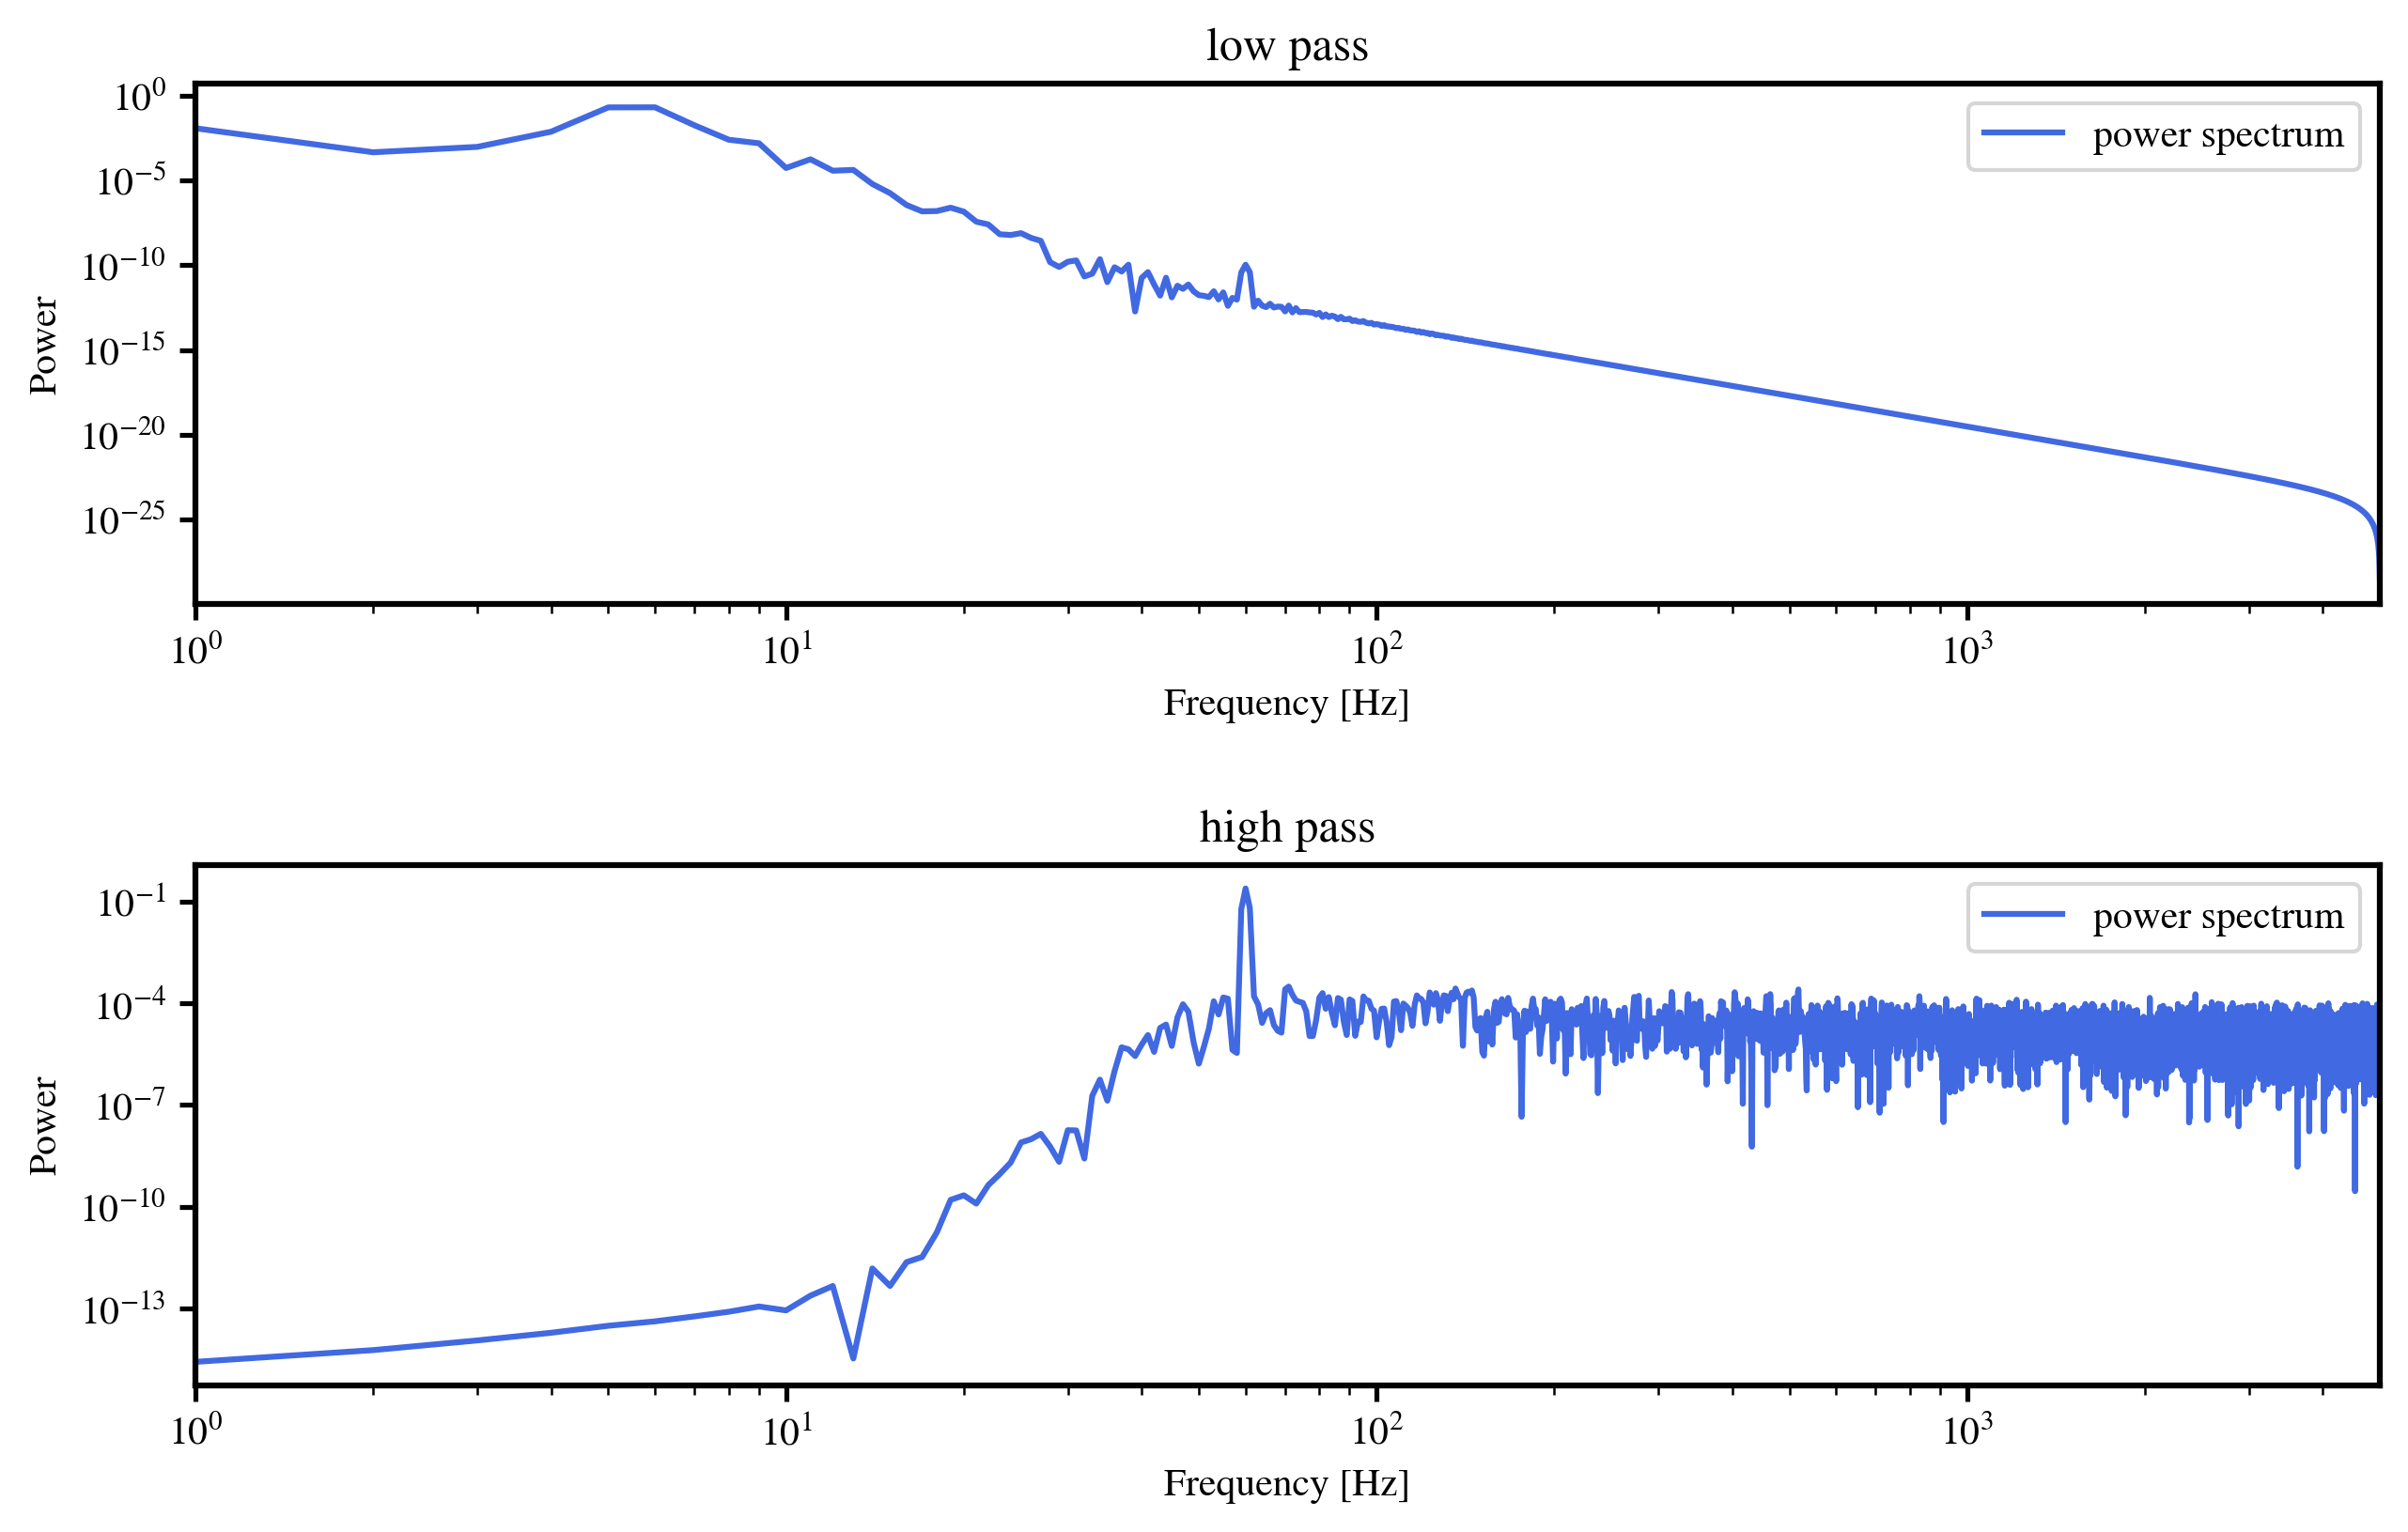

In [94]:
plt.close()


high_pass = signal.butter(8, 50, btype="hp", fs=10000, output="sos")
low_pass = signal.butter(6, 10, btype="lp", fs=10000, output="sos")

## apply filters

high_pass_apply = signal.sosfilt(high_pass, dataframe["total"])
dataframe["hp_data"] = high_pass_apply * np.hanning(len(high_pass_apply))
fft_first = np.fft.fft(dataframe["hp_data"])
fft_first_pos_hp = fft_first[k > 0]

hp_d1 = np.power(abs(fft_first_pos_hp), 2) / len(fft_first_pos_hp) ** 2
fft_frame["total_density_hp"] = hp_d1

low_pass_apply = signal.sosfilt(low_pass, dataframe["total"])
dataframe["lp_data"] = low_pass_apply * np.hanning(len(low_pass_apply))
fft_first = np.fft.fft(dataframe["lp_data"])
fft_first_pos_lp = fft_first[k > 0]

lp_d1 = np.power(abs(fft_first_pos_lp), 2) / len(fft_first_pos_hp) ** 2
fft_frame["total_density_lp"] = lp_d1

pass_list = ["lp", "hp"]
title_list = ["low pass", "high pass"]
## plotting

# make axes
fig = plt.figure(figsize=(10, 6))
gspec = fig.add_gridspec(2, hspace=0.5)
axs = gspec.subplots(sharex=False, sharey=False)

for ax_i, ax in enumerate(axs):

    # data
    data = ax.plot(
        fft_frame["frequency"],
        fft_frame[f"total_density_{pass_list[ax_i]}"],
        label="power spectrum",
    )
    # axes
    ax.set_xscale("log")
    ax.set_yscale("log")

    # titles
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Power")

    # limits
    ax.set_xlim(right=np.amax(fft_frame["frequency"]))
    ax.set_xlim(left=np.amin(fft_frame["frequency"]))
    ax.set_title(title_list[ax_i])

    ax.legend()

plt.show()

# Q2 - Working with images and what that negative k-correction actually means for sources. (30 pts)

In your last homework assignment, you whined about calculating the k-correction for some sub-mm galaxy.

So lets give you a more visual picture of what the negative k-correction actually does.
First, download and install DS9: http://ds9.si.edu/site/Home.html (or using conda)

Next, download the .fits files here: 
https://www.dropbox.com/scl/fo/pdcu1svt369dr5kshuq79/ALqZX0apyaqhxKO-qdjy-vg?rlkey=5y2hyqmlgzpjvn96whd1w348f&dl=0 

These are optical g,r,i DES images, an SPT 220GHz image, and an ALMA 870um image. Use Python to read in the .fits images.

In each case below, print your answer clearly (6 pts a piece) 
- Calculate the standard deviation of the SPT and ALMA maps. This is the noise.
- Now calculate the maximum signal-to-noise ratio in each map.
- Make a 3-color image from DES in DS9 (hint: Frame —> New Frame RGB in ds9 or use trilogy: https://pypi.org/project/trilogy/)
- Overplot the SPT contours at 3,5,7,9 sigma (hint: Analysis—> Contour Parameters in ds9 or use scipy.stats)
- Overplot the ALMA contours at 5,10,15,20 sigma.

It should look something like this:
https://www.dropbox.com/scl/fi/bllp2l5293w4cb8eg5dyz/prob3_example.png


  


In [86]:
## file loading
ALMA_filename = "FITS/SPT0538-50_ALMA_870um.fits"
ALMA_import = fits.open(ALMA_filename)
ALMA_data = ALMA_import[0].data[0, 0, :, :]
ALMA_header = ALMA_import[0].header

SPT_filename = "FITS/SPT0538-50_SPT_220GHz.fits"
SPT_import = fits.open(SPT_filename)
SPT_data = SPT_import[0].data
SPT_header = SPT_import[0].header

In [87]:
## what's the sigma?
ALMA_mean, ALMA_median, ALMA_std = sigma_clipped_stats(ALMA_data)
SPT_mean, SPT_median, SPT_std = sigma_clipped_stats(SPT_data)

## contour levels
ALMA_bases = np.array([5, 10, 15, 20])
SPT_bases = np.array([3, 5, 7, 9])

## final values
ALMA_levels = ALMA_bases * ALMA_std
SPT_levels = SPT_bases * SPT_std

## printouts
print("ALMA sigma:", ALMA_std)
print("SPT sigma:", SPT_std)
print("\n")
print("Maximum ALMA SNR:", np.amax(ALMA_data) / ALMA_std)
print("Maximum SPT SNR:", np.amax(SPT_data) / SPT_std)
print("\n")
print("ALMA contour levels:", ALMA_levels)
print("SPT contour levels:", SPT_levels)

ALMA sigma: 0.00045880597
SPT sigma: 7.642064e-05


Maximum ALMA SNR: 57.334248
Maximum SPT SNR: 8.916701


ALMA contour levels: [0.00229403 0.00458806 0.00688209 0.00917612]
SPT contour levels: [0.00022926 0.0003821  0.00053494 0.00068779]


Apologies for the poor quality, DS9 did NOT want to cooperate with me.

![alt text](FITS/big.jpg "ballin!")
![alt text](FITS/small.jpg "ballin!")

# Q3 - Coordinates, time conversions (30 pts) 

The star Vega (which you all know and love by now) has RA = 18h 36m 56s and Declination +38 deg 47' 01".

- Convert these coordinates

  a) decimal degrees ✅

  b) into galactic coordinates ✅

The University of Illinois observatory is at latitutde 40.112 degrees, while our longitude is -88.221 degrees.

- Use the expressions in the class slides to write a function that accepts arbitrary coordinates in RA and Dec and calculates the rise and set time of this source over the course of 2024.
  
- Plot the rise and set and set time of Vega for 2024
  

In [88]:
plt.close()
## decimal convert function


def decimal_convert(RA, Dec):

    ## string to float

    ## RA
    h_split = RA.split("h")[0]
    h_val = float(h_split[-2:])

    m_split = RA.split("m")[0]
    m_val = float(m_split[-2:])

    s_split = RA.split("s")[0]
    s_val = float(s_split[-5:])

    ## dec
    d_split = Dec.split("d")[0]
    d_val = float(d_split[-3:])
    d_sign = float(d_split[0] + "1")

    am_split = Dec.split("m")[0]
    am_val = float(am_split[-2:])

    as_split = Dec.split("s")[0]
    as_val = float(as_split[-4:])

    ## convert to degrees

    ## RA
    h_deg = h_val * 15
    m_deg = m_val * (15 / 60)
    s_deg = s_val * (15 / 3600)
    RA_deg = h_deg + m_deg + s_deg

    ## dec
    d_deg = abs(d_val)
    am_deg = am_val / 60
    as_deg = as_val / 3600
    Dec_deg = d_sign * (d_deg + am_deg + as_deg)

    return RA_deg, Dec_deg


## galactic coordinate conversion function
RA_ngp = "12h51m26.28s"
Dec_ngp = "+27d07m42.01s"
l_NCP = 122.932

RA_ngp_deg, Dec_ngp_deg = decimal_convert(RA_ngp, Dec_ngp)
RA_ngp_rad = np.radians(RA_ngp_deg)
Dec_ngp_rad = np.radians(Dec_ngp_deg)


def galactic_convert(RA, Dec):

    # convert input coordinates
    RA_deg, Dec_deg = decimal_convert(RA, Dec)
    RA_rad = np.radians(RA_deg)
    Dec_rad = np.radians(Dec_deg)
    l_NCP_rad = np.radians(l_NCP)

    ## b calculation

    # b calculation
    sin_b = (np.sin(Dec_ngp_rad) * np.sin(Dec_rad)) + (
        np.cos(Dec_ngp_rad) * np.cos(Dec_rad) * np.cos(RA_rad - RA_ngp_rad)
    )
    b = np.arcsin(sin_b)

    # l calculation
    sin_delta_l = (np.cos(Dec_rad) * np.sin(RA_rad - RA_ngp_rad)) / np.cos(b)
    l = l_NCP_rad - np.arcsin(sin_delta_l)

    return np.degrees(l), np.degrees(b)


l_vega, b_vega = galactic_convert("18h36m56.00s", "+38d47m01.00s")
RA_vega, Dec_vega = decimal_convert("18h36m56.00s", "+38d47m01.00s")
print("Vega RA, Dec:", np.round(RA_vega, 5), np.round(Dec_vega, 5))
print("Vega l, b:", np.round(l_vega, 2), np.round(b_vega, 2))

Vega RA, Dec: 279.23333 38.78361
Vega l, b: 67.45 19.23


In [89]:
## calculations

# constants
lat_deg = 40.112
lon_E_deg = -88.221
lon_E_hours = lon_E_deg / 15


def rise_set_calc(RA, Dec, days_past):

    # find RA and Dec in degrees
    RA_deg, Dec_deg = decimal_convert(RA, Dec)  ## correct

    # convert RA and Dec to hours
    RA_hours = RA_deg / 15  ## correct

    # find hour angle in hours
    HA_arg = -np.tan(np.radians(lat_deg)) * np.tan(np.radians(Dec_deg))
    HA_degrees = np.degrees(np.arccos(HA_arg))
    HA_hours = HA_degrees / 15

    # find LST of rise and set in hours
    LST_rise_hours = (24 + RA_hours - HA_hours) % 24
    LST_set_hours = (RA_hours + HA_hours) % 24

    # convert LSTs to GSTs
    GST_rise_hours = (LST_rise_hours - lon_E_hours) % 24
    GST_set_hours = (LST_set_hours - lon_E_hours) % 24

    # find the GMST based on the days past 1/1/2000
    date_1 = datetime(2000, 1, 1, 0)
    date_2 = datetime(2024, 1, 1, 0)

    start_delta = (date_2 - date_1).days
    delta_days = start_delta + days_past

    T = delta_days / 36525

    GMST_midnight = (6.697375 + (0.065709824279 * delta_days) + (0.0000258 * T**2)) % 24

    # find rise and set times relative to midnight
    UT_set = (GST_set_hours - GMST_midnight) % 24
    UT_rise = (GST_rise_hours - GMST_midnight) % 24

    # daylight savings checks
    dst_start = datetime(2024, 3, 10, 0)
    dst_end = datetime(2024, 11, 3, 0)

    dst_start_diff = (dst_start - date_2).days
    dst_end_diff = (dst_end - date_2).days

    # convert to local time
    if days_past > dst_start_diff and days_past < dst_end_diff:
        Local_set = (UT_set - 5) % 24
        Local_rise = (UT_rise - 5) % 24
    else:
        Local_set = (UT_set - 6) % 24
        Local_rise = (UT_rise - 6) % 24

    return Local_set, Local_rise

In [90]:
## label makers
month_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tick_array = []
tick_label_array = []

for i, month in enumerate(month_list):

    year_start = datetime(2024, 1, 1, 0)
    month_start = datetime(2024, month, 1, 0)

    day_diff = (month_start - year_start).days
    label = f"2024-{month}-1"

    tick_array.append(day_diff)
    tick_label_array.append(label)

2.5060298738341267 8.82537107470538


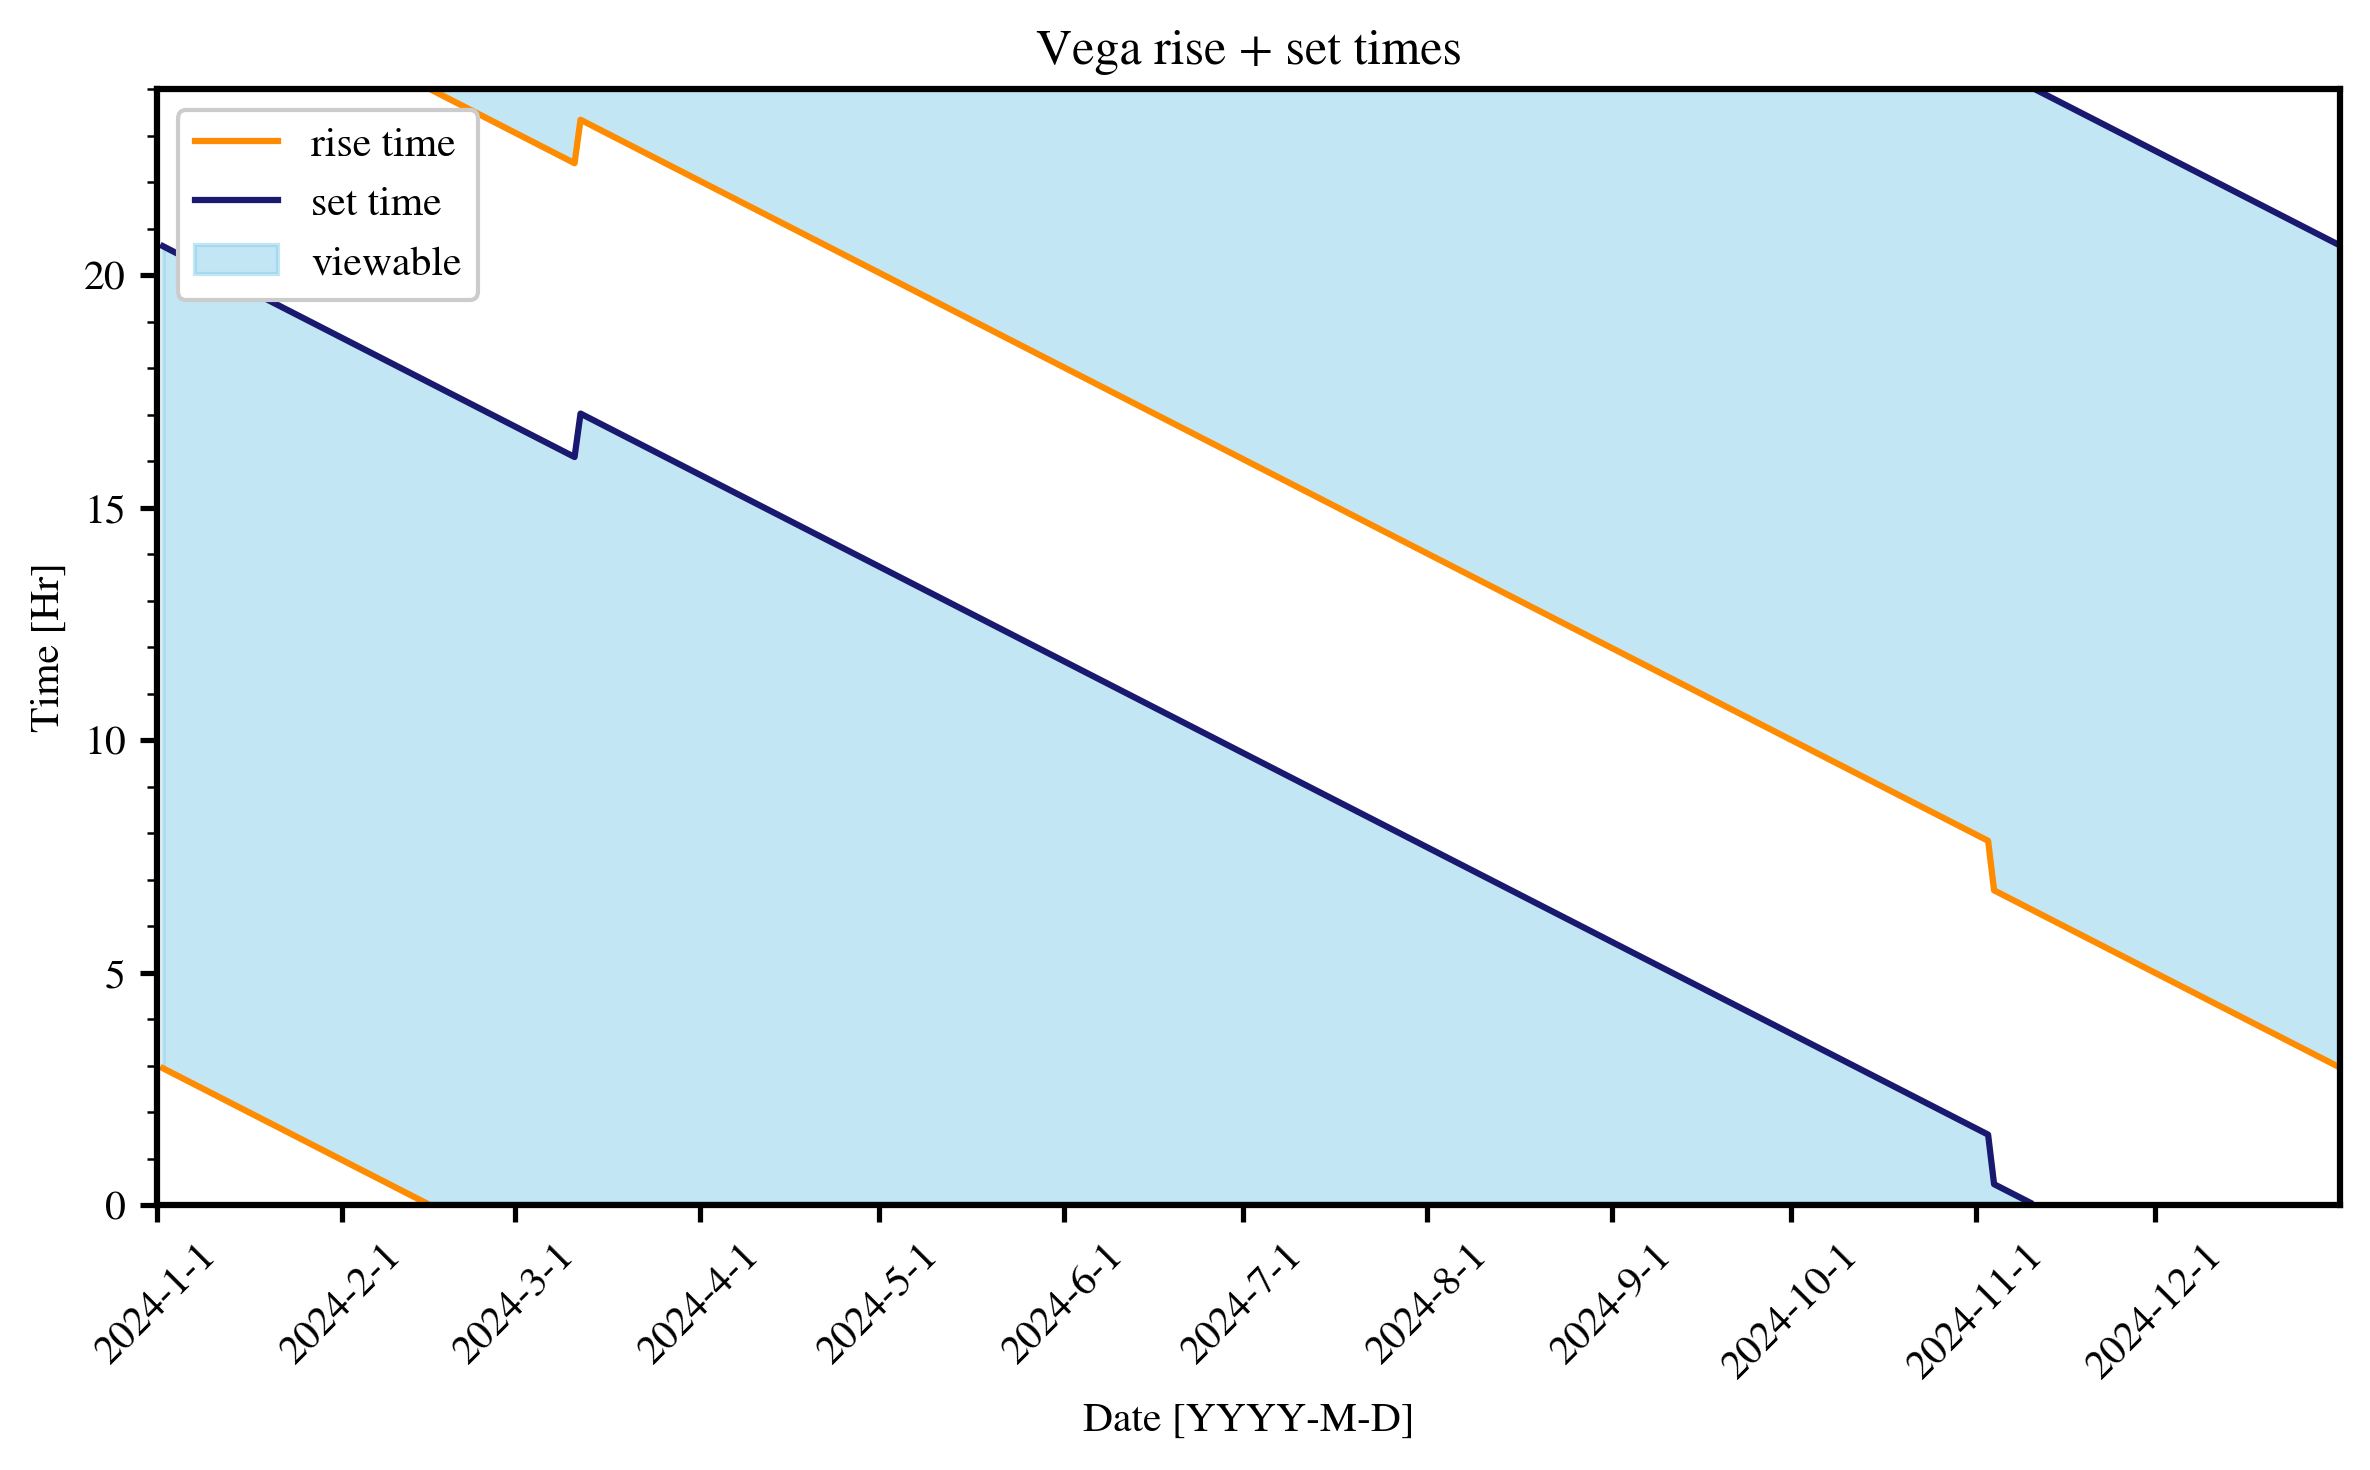

In [91]:
## arrays
set_array = np.zeros(366)
rise_array = np.zeros(366)
date_array = np.linspace(1, 366, 366)

## loop
for date in range(0, 366):
    set_time, rise_time = rise_set_calc("18h36m56.00s", "+38d47m01.00s", date)
    set_array[date] = set_time
    rise_array[date] = rise_time


print(set_array[291], rise_array[291])

## array cropping for a nice plot
rise_low = rise_array[rise_array <= rise_array[0]]
rise_high = rise_array[rise_array > rise_array[0]]

set_low = set_array[set_array <= set_array[0]]
set_high = set_array[set_array > set_array[0]]

date_rise_low = date_array[rise_array <= rise_array[0]]
date_rise_high = date_array[rise_array > rise_array[0]]

date_set_low = date_array[set_array <= set_array[0]]
date_set_high = date_array[set_array > set_array[0]]

## fill between interps
lower_interp = np.interp(date_set_low, date_rise_low, rise_low)
upper_interp = np.interp(date_rise_high, date_set_high, set_high)


## plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(date_rise_low, rise_low, c="darkorange", label="rise time")
ax.plot(date_rise_high, rise_high, c="darkorange")

ax.plot(date_set_low, set_low, c="midnightblue", label="set time")
ax.plot(date_set_high, set_high, c="midnightblue")


ax.set_xticks(tick_array, tick_label_array, rotation=45)
ax.fill_between(
    date_set_low,
    lower_interp,
    set_low,
    alpha=0.5,
    color="skyblue",
    label="viewable",
)

ax.fill_between(
    date_rise_high,
    upper_interp,
    rise_high,
    alpha=0.5,
    color="skyblue",
)

ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.legend(loc=2, framealpha=1)
ax.set_xlabel("Date [YYYY-M-D]")
ax.set_ylabel("Time [Hr]")
ax.set_title("Vega rise + set times")
ax.set_xlim([0, 366])
ax.set_ylim([0, 24])
plt.tight_layout()
plt.show()

In [92]:
plt.close()

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 22 at Noon!